In [38]:
#Classification of MNIST dataset 
push!(LOAD_PATH, "/home/jberez/Projects/MNIST/dockeropt")

using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats
using IterTools #Only for plots, not for program
using Serialization
using BNN

include("dockeropt/utils.jl");
include("dockeropt/LoadData.jl");

In [39]:
#Read Optdigits CSV
#using CSV
#using DataFrames

#test = CSV.read("dockeropt/optdigits.csv", DataFrame)
#y_total = Array(test[:,65]) .+ 1
#x_total = Array(test[:,1:64]);
#x_total = [Float64(i) for i in x_total]
x_total = deserialize("dockeropt/optdigits_x.jld")
y_total = deserialize("dockeropt/optdigits_y.jld")

#display(x_total[1:5,:])

dx = fit(ZScoreTransform, x_total, dims=2)
StatsBase.transform!(dx, x_total);

#display(x_total[1:5,:])

In [ ]:
#Load Train and Test Sets

function balanced_set(x,y,n,c,seed=0)
    
    if seed != 0
        Random.seed!(seed)
    end
    
    shuffled_indices = shuffle(1:length(y))
    x = x[shuffled_indices,:]
    y = y[shuffled_indices]
    
    x_ordered = zeros(Float64,n*c,64)
    y_ordered = zeros(Int,n*c)
    for k=1:c
        labels = [i for i in 1:length(y) if y[i]==k]
        x_ordered[k*n-(n-1):k*n,:] = x[labels,:][1:n,:]
        y_ordered[k*n-(n-1):k*n] = y[labels][1:n]
    end
    return x_ordered, y_ordered
end

function reshape_x(x)
    n = size(x)[1]
    println(n)
    x_reshaped = zeros(Float64, 8, 8, n)
    for i=1:n
        test = reshape(x[i,:], (1,8,8))
        x_reshaped[:,:,i] = reshape(x[i,:], (8,8))
    end
    return x_reshaped
end;

#Load the OptDigits Data
num_samples = 10
num_classes = 10

x_train, y_train = balanced_set(x_total,y_total,num_samples,num_classes,1);
x_test, y_test = balanced_set(x_total,y_total,num_samples,num_classes,2);

In [40]:
#folder = "/Data/BostonLong/"
folder = "/Data/Opt2/"
traces = []
tests = [i for i=1:16]
#filename_pre = "trace"
filename_pre = "OPTtrace"
filename_end = "output.jld"

#good_traces = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
good_traces = [1,2,3,4]

for i in good_traces
    current_file = join([pwd(),folder,filename_pre,"$(tests[i])", filename_end])
    current_traces = deserialize(current_file)
    push!(traces,current_traces)
end;
chains = length(traces);

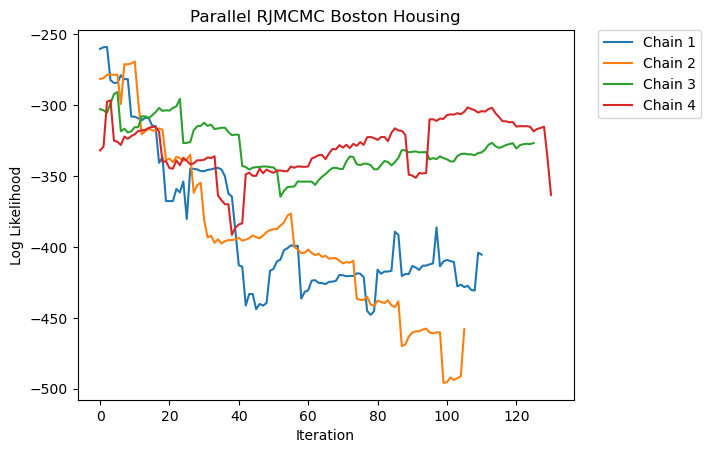

In [41]:
#Plot Log Posterior for Each Chain

for i=1:chains
    scores = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        scores[j] = get_score(trace)
    end
    plot(scores,label="Chain $i")
end
plt.title("Parallel RJMCMC Boston Housing")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood");
#plt.ylim(-500,-100)

legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);

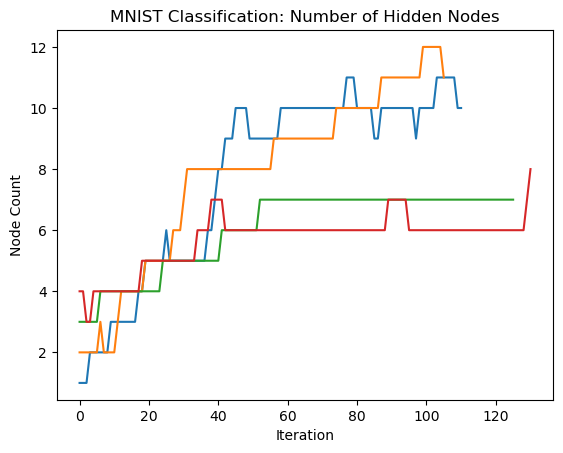

In [42]:
#Node Count Chart
for i=1:chains
    plot([trace[(:k,1)] for trace in traces[i]])
end
plt.title("MNIST Classification: Number of Hidden Nodes")
plt.xlabel("Iteration")
plt.ylabel("Node Count");

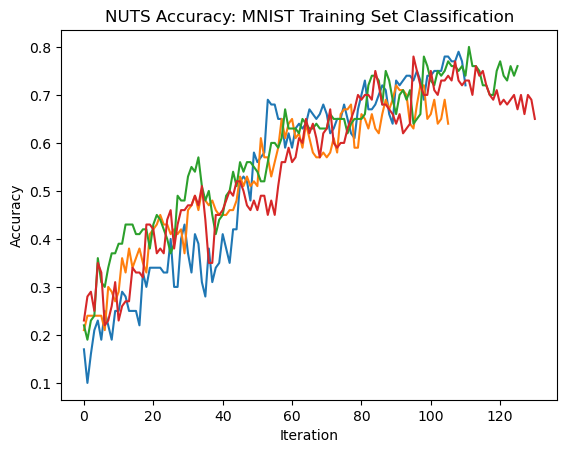

In [43]:
#Plot Training Accuracy
for v=1:chains
    active_traces = traces[v]
    accs = []
    dists = []
    for i = 1:length(active_traces)
        trace = active_traces[i]
        test_labels = G(xt,trace)
        results = label_output(test_labels)
        test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
        test_dist = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
        push!(accs,test_acc)
        push!(dists,test_dist)
    end
    plot(accs)
end

plt.title("NUTS Accuracy: MNIST Training Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

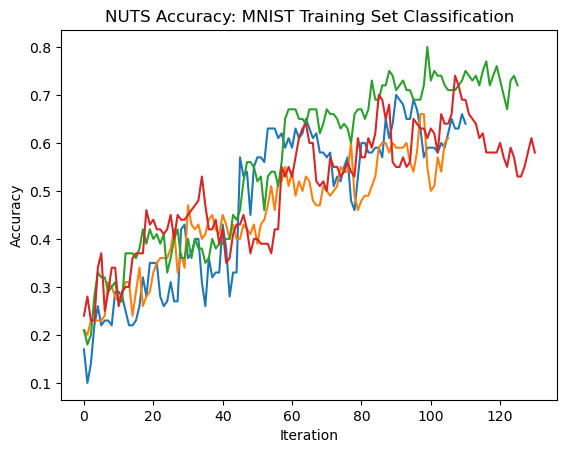

In [44]:
#Plot Test Accuracy
for v=1:chains
    active_traces = traces[v]
    accs = []
    dists = []
    for i = 1:length(active_traces)
        trace = active_traces[i]
        test_labels = G(xz,trace)
        results = label_output(test_labels)
        test_acc = sum([y_test[i] == results[i] for i=1:length(y_test)])/length(y_test)
        test_dist = sum([euclidean(yzt[:,j],test_labels[:,j]) for j=1:length(y_test)])
        push!(accs,test_acc)
        push!(dists,test_dist)
    end
    plot(accs)
end

plt.title("NUTS Accuracy: MNIST Training Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

In [51]:
#Marginalize Probabilities - Train Set
j = 1
c = 10
N = 100
total_count = sum([length(traces[i]) for i=1:chains])
targets = zeros(total_count-(chains*j),c,N)
for v=1:chains
    active_traces = traces[v]
    count = 1
    for i=j:length(active_traces)-j
        trace = active_traces[i]
        labels = G(xt,trace)
        targets[count,:,:] = labels
        count += 1
    end
end

sums = sum(targets,dims=1)[1,:,:]./(total_count)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y[i] == guesses[i] for i=1:length(y)])
println("Training set accuracy: $test_acc")



Training set accuracy: 82


In [50]:
#Marginalize Probabilities - Test Set
j = 1
c = 10
N = 100
total_count = sum([length(traces[i]) for i=1:chains])
targets = zeros(total_count-(chains*j),c,N)
for v=1:chains
    active_traces = traces[v]
    count = 1
    for i=j:length(active_traces)-j
        trace = active_traces[i]
        labels = G(xz,trace)
        targets[count,:,:] = labels
        count += 1
    end
end

sums = sum(targets,dims=1)[1,:,:]./(total_count)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y_test[i] == guesses[i] for i=1:length(y_test)])
println("Training set accuracy: $test_acc")



Training set accuracy: 73
